In [3]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import datasets, metrics
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

# Assignment
In this assignment, we'll be working with the [heart disease dataset](http://archive.ics.uci.edu/ml/datasets/Heart+Disease) from the UC Irvine Machine Learning Repository.

## 1. Split the data randomly into two and apply k-means using two, three and four as the number of clusters as we did in our discussion of the consistency in this checkpoint. Assess the consistency of the solutions using visualization. Which one does seem to be the best one?

### Load the Dataset

In [2]:
#Database Credentials:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

# use the credentials to start a connection
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# Use the connection to extract SQL data
heartdisease_df = pd.read_sql_query('SELECT * FROM heartdisease', con=engine)

# Close the connection
engine.dispose()

### Pre-Processing

In [25]:
#Make sure the dataset has an even number of rows, for the half split
df_even = heartdisease_df.iloc[:(len(heartdisease_df) - len(heartdisease_df)%2), :]

# Define the features and the outcome
X = df_even.iloc[:, :13]
y = df_even.iloc[:, 13]

# Replace missing values (marked by ?) with a 0
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis
y = np.where(y > 0, 0, 1)

# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

### Split the Dataset

In [26]:
# Split the data into two equally-sized samples. 
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split( X_std, X_pca, test_size=0.5, random_state=13579)


### Apply K-Means on Subsamples with 2, 3, and 4 Clusters

In [27]:
# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[counter])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

### Visualize to Check for Consistency

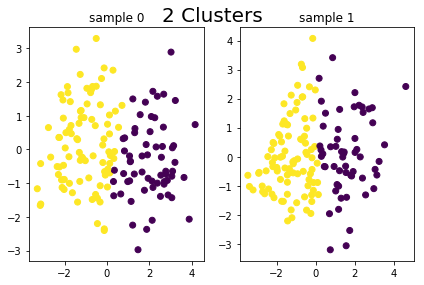

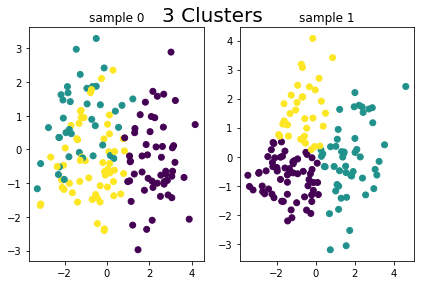

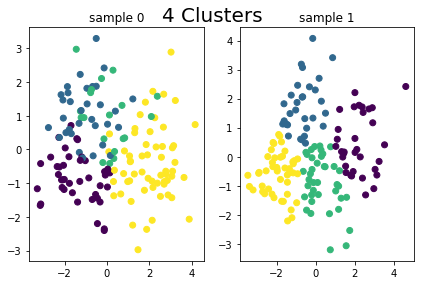

In [28]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

Only the 2-cluster solution has consistent results.

## 2. Apply k-means on the whole dataset by setting k is equal two, three and four and get ARI score for each of them. Which model is the best?

In [29]:
for nclust in range(2, 5):
    pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(X_std)
    print("ARI for {} cluster k-means: {}".format(nclust, metrics.adjusted_rand_score(y, pred)))

ARI for 2 cluster k-means: 0.43661540614807665
ARI for 3 cluster k-means: 0.280694132678885
ARI for 4 cluster k-means: 0.1968993286830863


These results show that the 2-cluster k-mean provides the highest level of accuracy, which is what we already expected from the visualization. However, it's important to note that the ARI of 0.44 is less than 50%, so that means our best k-mean clustering is more similar to random than it is to perfect.

## 3. Apply k-means on the whole dataset by setting k equal to two, three and four and get silhouette coefficient for each of them. Which model is the best?

In [31]:
for nclust in range(2, 5):
    pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(X_std)
    print("Silhouette score for {} cluster k-means: {}".format(nclust, metrics.silhouette_score(X_std, pred, metric='euclidean')))

Silhouette score for 2 cluster k-means: 0.17440650461256255
Silhouette score for 3 cluster k-means: 0.1286219070218783
Silhouette score for 4 cluster k-means: 0.13186062012858554


The silhouette score for 2-cluster is once again higher than the scores for 3- or 4-cluster, so the 2-cluster model is the best. Again, it's important to note that these values are all pretty low, so even though the 2-cluster is the best of the three options, there are probably other models out there with higher accuracy.